# Data Analysis for ACEEE paper


## Load Libraries

In [1]:
%matplotlib inline
#TODO: The `IPython.kernel` package has been deprecated. import from ipykerneljupyter_client instead.
#import dataMerging as dm
import pandas as pd
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from sklearn import svm, cross_validation, linear_model, preprocessing
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

matplotlib.style.use('ggplot')

## Load Data , Fix types, Eliminate blacklist

In [2]:
# load data
data_raw = pd.read_csv('AllData_20160302.csv', index_col=0) 
# load list of people to exclude
exclude=pd.read_csv('black_list.csv', index_col=0) 
# remove rows of people in the black list with Join
data=data_raw.join(exclude, on="mailAddress", how="left")
data=data[pd.isnull(data["firstName_"])]
data.drop(["firstName_","lastName_"],axis=1, inplace=True)
# format timestamp as date_time
data.loc[:,"timestamp"]=pd.to_datetime(data.loc[:,"timestamp"])
data.columns

Index([u'timestamp', u'path', u'path_index', u'is_complete', u'username',
       u'ucdPersonUuid', u'firstName', u'lastName', u'mailAddress',
       u'isFaculty', u'isStaff', u'isStudent', u'building', u'buildingKey',
       u'room', u'comment', u'comfort', u'satisfaction', u'conserveVote1',
       u'conserveVote1b', u'conserveVote2', u'conserveVote2b', u'sourceName',
       u'sourceKey', u'isFavorite'],
      dtype='object')

## Manipulate and Add Variables for Calculation

In [3]:
### map categorical variables into numbers for plots
# comfort in numbers
comfort_num = {'Perfect':0, 'Chilly':-1, 'Cold':-2, 'Hot':+2, 'Warm':+1}
data.loc[:,'comfort_num']=data['comfort'].map(comfort_num)
# satisfaction in numbers
satisfaction_num = {'Very Satisfied':+2, 'Somewhat Satisfied':+1, 'Neutral':0, 
                    'Somewhat Dissatisfied':-1,'Very Dissatisfied':-2}
data.loc[:,'satisfaction_num']=data['satisfaction'].map(satisfaction_num)

In [4]:
### create categorical variable for Student-Staff-Faculty
# staff faculty student to categorical variable
data['isWhat_num'] = np.nan
data['isWhat_num']=data['isStudent']*1 +data['isStaff']*3 + data['isFaculty']*5
isWhat= {1:"Student", 4:'Student', 3:'Staff', 5: 'Faculty'}
data['isWhat']=data['isWhat_num'].map(isWhat)

# conditions on rows to subsample
cond_stu=data["isWhat"]=="Student"
cond_sta=data["isWhat"]=="Staff"
cond_fac=data["isWhat"]=="Faculty"
# list to use in for loop
cond_list=[cond_stu,cond_sta,cond_fac]
# list for labels
labels=["Students","Staff", "Faculty"]

In [5]:
## add time variables
data["YEAR"]=data["timestamp"].dt.year
data["MONTH"]=data["timestamp"].dt.month
data["DAY"]=data["timestamp"].dt.day


## Exploratory Plots
### Total number of voters per type

isWhat              7470
comfort_num          595
satisfaction_num     772
dtype: int64


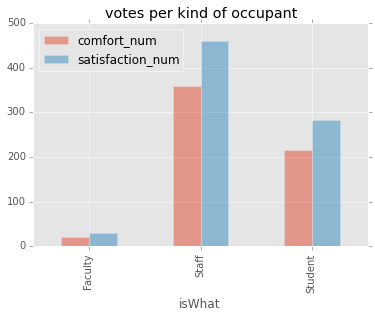

In [6]:
col=['isWhat','comfort_num','satisfaction_num']
data.loc[:,col].groupby("isWhat").count().plot(kind="bar",alpha=0.5).set_title('votes per kind of occupant');
print data.loc[:,col].count()

### Histogram: Votes per person

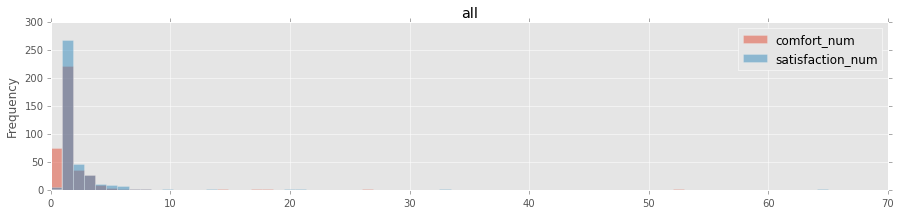

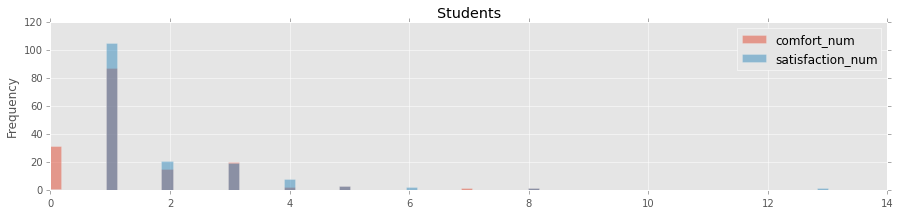

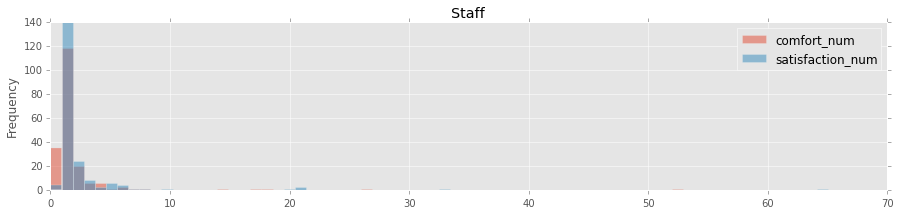

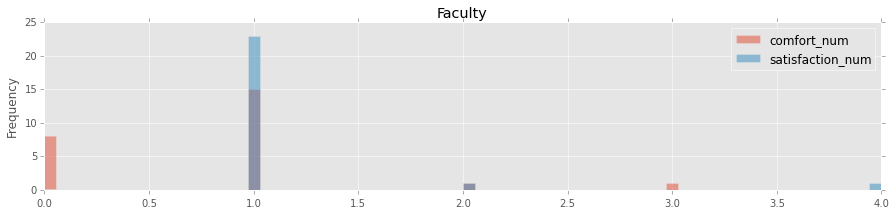

In [7]:
# frequencies of votes per person 
col=['mailAddress','comfort_num','satisfaction_num']
# all together
data.loc[:,col].dropna(thresh=2).groupby(["mailAddress"]).count().plot(kind='hist',
                                                                 alpha=0.5,
                                                                 bins=70,
                                                                 figsize=(15,3)).set_title('all');
i=0
for occ_type in cond_list:
    grouped=data.loc[occ_type,col].dropna(thresh=2).groupby(["mailAddress"]).count()
    grouped.plot(kind='hist',alpha=0.5,bins=70,figsize=(15,3)).set_title(labels[i]);
    i+=1

### Table: rank most voted buildings

,comfort_num,satisfaction_num
building,,
University Services Building,102,102
USB,73,73
Dutton Hall,33,33
PES (Plant & Environmental Sciences),28,28
Bainer Hall,22,22
Young Hall,19,19
Haring Hall,17,17
Silo South,15,15
Hunt Hall,14,14


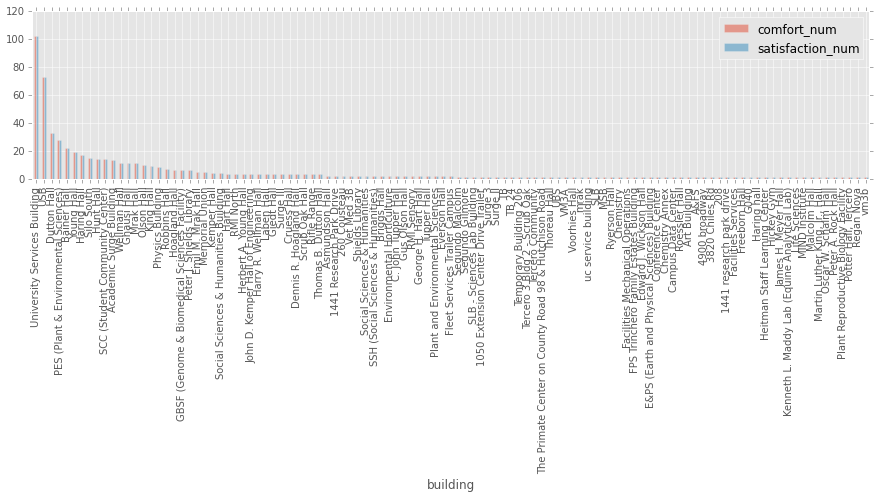

In [8]:
col=['building','comfort_num','satisfaction_num']

# plot
data.loc[:,col].dropna().groupby("building").count().sort_values('comfort_num',ascending=False).plot(kind="bar", 
                                                                                                           figsize=(15,3), 
                                                                                                           alpha=0.5)
# table
data.loc[:,col].dropna().groupby("building").count().sort_values('comfort_num',ascending=False).head(10)

### Number of votes per month

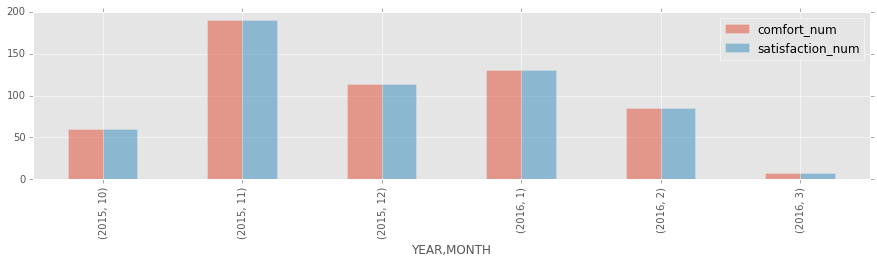

In [10]:
col=['YEAR','MONTH','comfort_num','satisfaction_num']
# plot
data.loc[:,col].dropna().groupby(['YEAR','MONTH']).count().plot(kind="bar",figsize=(15,3), alpha=0.5)

### Number of votes per day

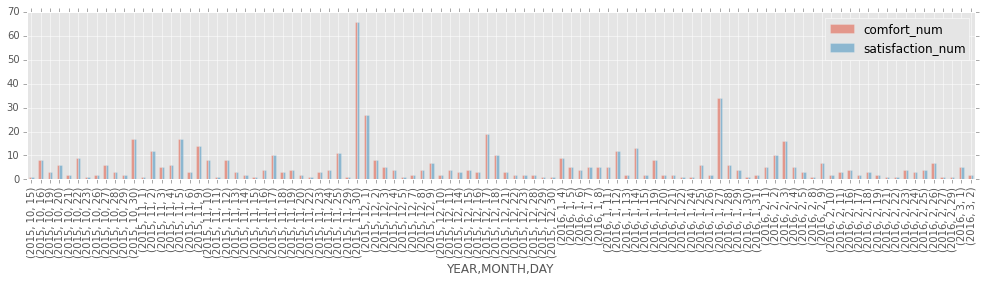

In [11]:
col=['YEAR','MONTH','DAY','comfort_num','satisfaction_num']
# plot
data.loc[:,col].dropna().groupby(['YEAR','MONTH', 'DAY']).count().plot(kind="bar",figsize=(17,3), alpha=0.5)

### Number of Votes vs Number of Buildings

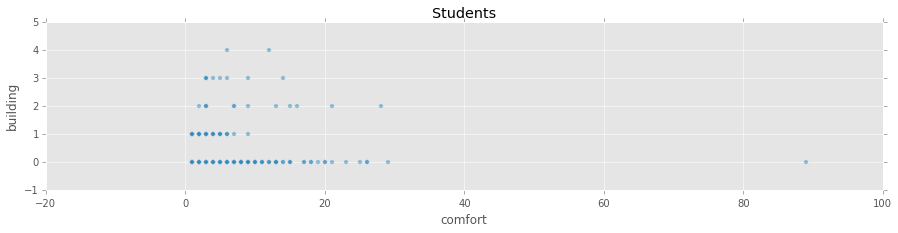

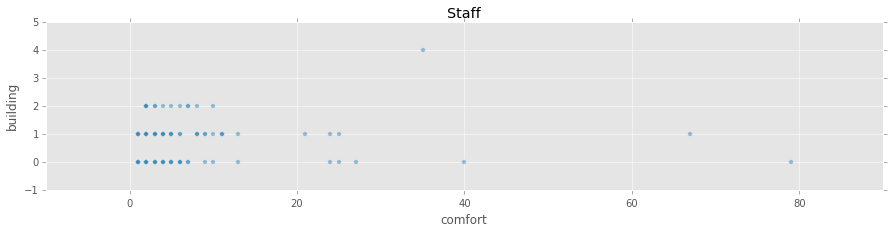

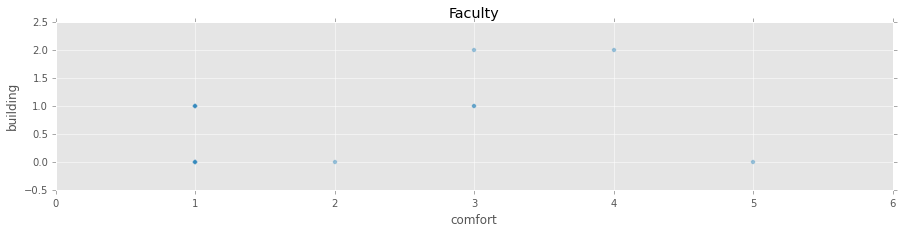

In [14]:
# number of votes vs # buildings they voted in
col=['mailAddress','isWhat','comfort','building']
i=0
for occ_type in cond_list:
    grouped=data.loc[occ_type, col].groupby("mailAddress")
    grouped.agg({'comfort':np.count_nonzero,'building':pd.Series.nunique}).plot(kind='scatter',
                                                                                 alpha=0.5,
                                                                                 figsize=(15,3),
                                                                                 y=col[3],
                                                                                 x=col[2]).set_title(labels[i]);
    i+=1

### Satisfaction vs Comfort Votes

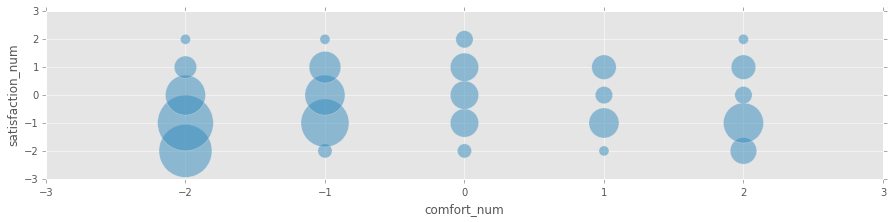

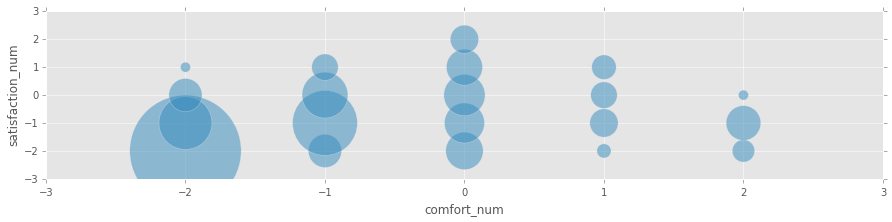

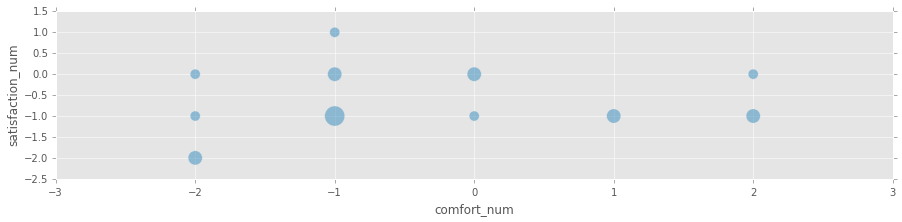

In [13]:
col=['mailAddress','satisfaction_num','comfort_num']
i=0
for occ_type in cond_list:
    grouped=data.loc[occ_type, col].groupby(['satisfaction_num','comfort_num']).count()
    new_table=grouped.reset_index()
    new_table.plot(kind='scatter',alpha=0.5,figsize=(15,3),y=col[1],x=col[2],s=new_table['mailAddress']*100)
    i+=1


In [126]:
### Clustering of users: to do
### 1) plot all to see if there are clear classes
### 2) run cluster using k-Mens (scikit-learn here:http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
